In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pickle
import os
import sys
import copy
from cleanlab import noise_generation

pp_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(pp_path)
os.environ["PYTHONPATH"] = pp_path + ":" + os.environ.get("PYTHONPATH", "")
from utils import *
pd.options.mode.chained_assignment = None # None / 'warn'
pd.set_option('display.max_columns', None)

In [2]:
### read dataset

# source: https://archive.ics.uci.edu/ml/datasets/dataset+for+sensorless+drive+diagnosis
datapath = '../data_raw/SenDrive/Sensorless_drive_diagnosis.txt'
df = pd.read_csv(datapath, sep=" ", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
0,-3.014600e-07,8.260300e-06,-0.000012,-0.000002,-1.438600e-06,-0.000021,0.031718,0.031710,0.031721,-0.032963,-0.032962,-0.032941,0.000769,0.000232,0.000600,0.000757,0.000247,0.000725,0.89669,0.89669,0.89669,0.89658,0.89658,0.89656,0.007680,0.257360,-0.711840,0.004879,-0.095775,-0.441260,-0.001317,-0.001319,-0.001248,-0.004378,-0.004384,-0.004389,-0.66732,4.3662,6.0168,-0.63308,2.9646,8.1198,-1.4961,-1.4961,-1.4961,-1.4996,-1.4996,-1.4996,1
1,2.913200e-06,-5.247700e-06,0.000003,-0.000006,2.778900e-06,-0.000004,0.030804,0.030810,0.030806,-0.033520,-0.033522,-0.033519,0.000766,0.000221,0.000485,0.000755,0.000252,0.000668,0.89583,0.89583,0.89580,0.89677,0.89677,0.89673,-0.009402,-0.059481,-0.295920,0.007111,0.119110,0.311170,0.001093,0.001091,0.001068,-0.001344,-0.001342,-0.001375,-0.65404,1.3977,3.6048,-0.59314,7.6252,6.1690,-1.4967,-1.4967,-1.4967,-1.5005,-1.5005,-1.5005,1
2,-2.951700e-06,-3.184000e-06,-0.000016,-0.000001,-1.575300e-06,0.000017,0.032877,0.032880,0.032896,-0.029834,-0.029832,-0.029849,0.000764,0.000230,0.000560,0.000758,0.000236,0.000712,0.89583,0.89583,0.89581,0.89619,0.89619,0.89621,0.005951,-0.075239,-0.228620,0.000445,-0.162300,0.562100,0.002894,0.002903,0.002885,0.000350,0.000358,0.000374,-0.67146,2.8072,5.8007,-0.63252,2.7784,5.3017,-1.4983,-1.4983,-1.4982,-1.4985,-1.4985,-1.4985,1
3,-1.322600e-06,8.820100e-06,-0.000016,-0.000005,-7.282900e-07,0.000004,0.029410,0.029401,0.029417,-0.030156,-0.030155,-0.030159,0.000770,0.000244,0.000753,0.000755,0.000257,0.000754,0.89480,0.89481,0.89479,0.89576,0.89576,0.89572,0.002056,0.466570,0.568410,0.006936,-0.467240,0.226730,-0.001255,-0.001242,-0.001277,-0.004974,-0.004966,-0.004976,-0.67766,7.8629,23.3960,-0.62289,6.5534,6.2606,-1.4963,-1.4963,-1.4963,-1.4975,-1.4975,-1.4976,1
4,-6.836600e-08,5.666300e-07,-0.000026,-0.000006,-7.940600e-07,0.000013,0.030119,0.030119,0.030145,-0.031393,-0.031392,-0.031405,0.000763,0.000249,0.000623,0.000756,0.000225,0.000612,0.89656,0.89656,0.89655,0.89521,0.89520,0.89520,-0.000860,-0.904870,-0.573950,0.005616,0.343380,0.843070,-0.003811,-0.003804,-0.003800,-0.004655,-0.004646,-0.004640,-0.65867,14.8720,5.0582,-0.63010,4.5155,9.5231,-1.4958,-1.4958,-1.4958,-1.4959,-1.4959,-1.4959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58504,-9.982500e-06,1.854900e-06,-0.000021,0.000021,-5.910200e-06,-0.000098,-0.083417,-0.083419,-0.083398,-0.182340,-0.182330,-0.182230,0.002979,0.001660,0.004295,0.002913,0.001623,0.005625,2.29100,2.29090,2.29060,2.29370,2.29360,2.29270,0.023419,-0.213470,0.427960,0.004317,0.117720,0.023982,-0.008224,-0.008227,-0.008362,0.001726,0.001733,0.001586,-0.41812,1.4688,7.3939,-0.52907,1.4641,7.0032,-1.5024,-1.5025,-1.5023,-1.4933,-1.4933,-1.4933,11
58505,-1.055400e-05,1.983500e-05,0.000031,-0.000018,-1.061600e-04,0.000292,-0.085131,-0.085151,-0.085182,-0.184320,-0.184220,-0.184510,0.002994,0.001795,0.004355,0.002913,0.001924,0.004647,2.29210,2.29200,2.29110,2.29490,2.29470,2.29410,0.015612,-0.118970,0.311410,0.007677,-0.662360,0.577120,-0.009869,-0.009877,-0.009709,-0.000064,0.000033,0.000826,-0.42137,1.6854,3.8550,-0.51971,3.3275,2.3072,-1.5024,-1.5025,-1.5024,-1.4925,-1.4925,-1.4926,11
58506,-5.857700e-06,1.859400e-05,-0.000102,-0.000003,3.827500e-06,0.000117,-0.081989,-0.082008,-0.081906,-0.186140,-0.186140,-0.186260,0.002991,0.001606,0.004915,0.002914,0.002720,0.007619,2.29070,2.29070,2.28960,2.29810,2.29790,2.29660,0.007406,0.247090,-0.456930,0.008709,1.944400,1.160200,-0.007831,-0.007869,-0.008109,0.000646,0.000523,0.000651,-0.39929,2.7057,12.6940,-0.51103,20.9250,9.0437,-1.5035,-1.5035,-1.5039,-1.4911,-1.4912,-1.4910,11
58507,-4.441100e-06,3.396900e-05,-0.000442,0.000005,6.500800e-06,0.000087,-0.081500,-0.081534,-0.081093,-0.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58509 entries, 0 to 58508
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       58509 non-null  float64
 1   1       58509 non-null  float64
 2   2       58509 non-null  float64
 3   3       58509 non-null  float64
 4   4       58509 non-null  float64
 5   5       58509 non-null  float64
 6   6       58509 non-null  float64
 7   7       58509 non-null  float64
 8   8       58509 non-null  float64
 9   9       58509 non-null  float64
 10  10      58509 non-null  float64
 11  11      58509 non-null  float64
 12  12      58509 non-null  float64
 13  13      58509 non-null  float64
 14  14      58509 non-null  float64
 15  15      58509 non-null  float64
 16  16      58509 non-null  float64
 17  17      58509 non-null  float64
 18  18      58509 non-null  float64
 19  19      58509 non-null  float64
 20  20      58509 non-null  float64
 21  21      58509 non-null  float64
 22

In [4]:
# check for missing values

df.isnull().sum().sum()

0

In [5]:
### preprocessing columns

df.rename(columns=lambda c: 'col'+str(c), inplace=True)

# assign the column name of the target feature as "Target"
df.rename(columns={'col48':"Target"}, inplace=True)

# make sure the label ranges from 0 to (num_class-1)
df["Target"] = LabelEncoder().fit_transform(df["Target"])


print('\ndata shape: ', df.shape, sep='')
print('\ncolumn names:\n', list(df.columns), sep='')
print('\nclass distribution:\n', df.Target.value_counts(), sep='')
print('\ncolumn types:\n', df.dtypes, sep='')


data shape: (58509, 49)

column names:
['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'col40', 'col41', 'col42', 'col43', 'col44', 'col45', 'col46', 'col47', 'Target']

class distribution:
10    5319
9     5319
8     5319
7     5319
6     5319
5     5319
4     5319
3     5319
2     5319
1     5319
0     5319
Name: Target, dtype: int64

column types:
col0      float64
col1      float64
col2      float64
col3      float64
col4      float64
col5      float64
col6      float64
col7      float64
col8      float64
col9      float64
col10     float64
col11     float64
col12     float64
col13     float64
col14     float64
col15     float64
col16     float64
col17     float64
col18     float64
c

In [6]:
categorical_features = [] ###
continuous_features = list(OrderedSet(df.columns.to_list()) - OrderedSet(["Target"]) - OrderedSet(categorical_features))
print('continuous_features:', continuous_features)
print('\ncategorical_features:', categorical_features)

continuous_features: ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'col40', 'col41', 'col42', 'col43', 'col44', 'col45', 'col46', 'col47']

categorical_features: []


In [7]:
df.describe(include='all')

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,Target
count,58509.000000,5.850900e+04,5.850900e+04,58509.000000,5.850900e+04,5.850900e+04,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000,58509.000000
mean,-0.000003,1.439648e-06,1.412013e-06,-0.000001,1.351239e-06,-2.654483e-07,0.001915,0.001913,0.001912,-0.011897,-0.011899,-0.011898,0.001876,0.001083,0.003092,0.001867,0.001077,0.003076,1.618319,1.618258,1.617787,1.617780,1.617723,1.617255,0.001909,0.008799,-0.003465,-0.000157,0.012089,-0.009958,0.000016,0.000014,0.000019,-0.000035,-0.000038,-0.000032,-0.463276,7.447186,8.406765,-0.397757,7.293781,8.273772,-1.500887,-1.500912,-1.500805,-1.497771,-1.497794,-1.497686,5.000000
std,0.000072,5.555429e-05,2.353009e-04,0.000063,5.660943e-05,2.261907e-04,0.036468,0.036465,0.036470,0.066482,0.066480,0.066477,0.001019,0.000667,0.002195,0.000950,0.000656,0.002131,0.399767,0.399740,0.399591,0.398151,0.398125,0.397965,0.196071,0.778815,0.873892,0.175249,0.763321,0.858768,0.007797,0.007792,0.007794,0.009886,0.009877,0.009871,20.395855,12.240765,6.897301,25.018728,12.451781,6.565952,0.003657,0.003668,0.003632,0.003163,0.003163,0.003175,3.162305
min,-0.013721,-5.414400e-03,-1.358000e-02,-0.012787,-8.355900e-03,-9.741300e-03,-0.139890,-0.135940,-0.130860,-0.218640,-0.218600,-0.218630,0.000751,0.000188,0.000354,0.000744,0.000189,0.000357,0.797640,0.797640,0.797630,0.798400,0.798400,0.798390,-15.796000,-12.351000,-7.959000,-11.903000,-12.508000,-9.976600,-0.050235,-0.051891,-0.052791,-0.337710,-0.337700,-0.337750,-0.912300,-0.618020,0.522180,-0.902350,-0.596830,0.320660,-1.525500,-1.526200,-1.523700,-1.521400,-1.523200,-1.521300,0.000000
25%,-0.000007,-1.444400e-05,-7.239600e-05,-0.000005,-1.475300e-05,-7.379100e-05,-0.019927,-0.019951,-0.019925,-0.032144,-0.032158,-0.032168,0.001137,0.000599,0.001257,0.001139,0.000598,0.001288,1.327400,1.327400,1.326700,1.328700,1.328700,1.328100,-0.006033,-0.205900,-0.453440,-0.009231,-0.203390,-0.448040,-0.005102,-0.005113,-0.005109,-0.004522,-0.004518,-0.004489,-0.714940,1.485300,4.451300,-0.715470,1.450300,4.436300,-1.503300,-1.503400,-1.503200,-1.499600,-1.499600,-1.499500,2.000000
50%,-0.000003,8.804600e-07,5.137700e-07,-0.000001,7.540200e-07,-1.659300e-07,0.013226,0.013230,0.013247,-0.015566,-0.015592,-0.015603,0.002199,0.001185,0.002980,0.002188,0.001182,0.002891,1.573200,1.573100,1.572900,1.572600,1.572500,1.572400,0.003020,0.006513,-0.000126,0.000168,0.008109,-0.004195,0.000452,0.000451,0.000461,-0.000278,-0.000274,-0.000274,-0.664020,3.300100,6.566800,-0.661710,3.301300,6.479100,-1.500300,-1.500300,-1.500300,-1.498100,-1.498100,-1.498000,5.000000
75%,0.000002,1.877700e-05,7.520000e-05,0.000004,1.906200e-05,7.138600e-05,0.024770,0.024776,0.024777,0.020614,0.020618,0.020602,0.002527,0.001456,0.004336,0.002523,0.001454,0.004322,1.885800,1.885700,1.884900,1.883400,1.883300,1.882500,0.011576,0.220960,0.445910,0.008671,0.225560,0.429030,0.005165,0.005165,0.005174,0.004960,0.004955,0.004967,-0.581950,8.372900,9.952600,-0.573980,8.288500,9.857500,-1.498200,-1.498200,-1.498200,-1.496200,-1.496300,-1.496200,8.000000
max,0.005784,4.525300e-03,5.237700e-03,0.001453,8.245100e-04,2.753600e-03,0.069125,0.069130,0.069131,0.352580,0.352560,0.352630,0.136570,0.051543,0.103930,0.108770,0.064764,0.078530,2

In [8]:
# shuffle and split data into train/(val)/test
seed = 0

train_fraction = 0.75 ###
df_train, df_test = shuffle_split_data(df, train_fraction, seed=seed)

print('train:', df_train.shape)
print(np.unique(df_train.Target, return_counts=True))
print('\ntest:', df_test.shape)
print(np.unique(df_test.Target, return_counts=True))

train: (43881, 49)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([3989, 3989, 3989, 3989, 3990, 3989, 3989, 3989, 3989, 3990, 3989]))

test: (14628, 49)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([1330, 1330, 1330, 1330, 1329, 1330, 1330, 1330, 1330, 1329, 1330]))


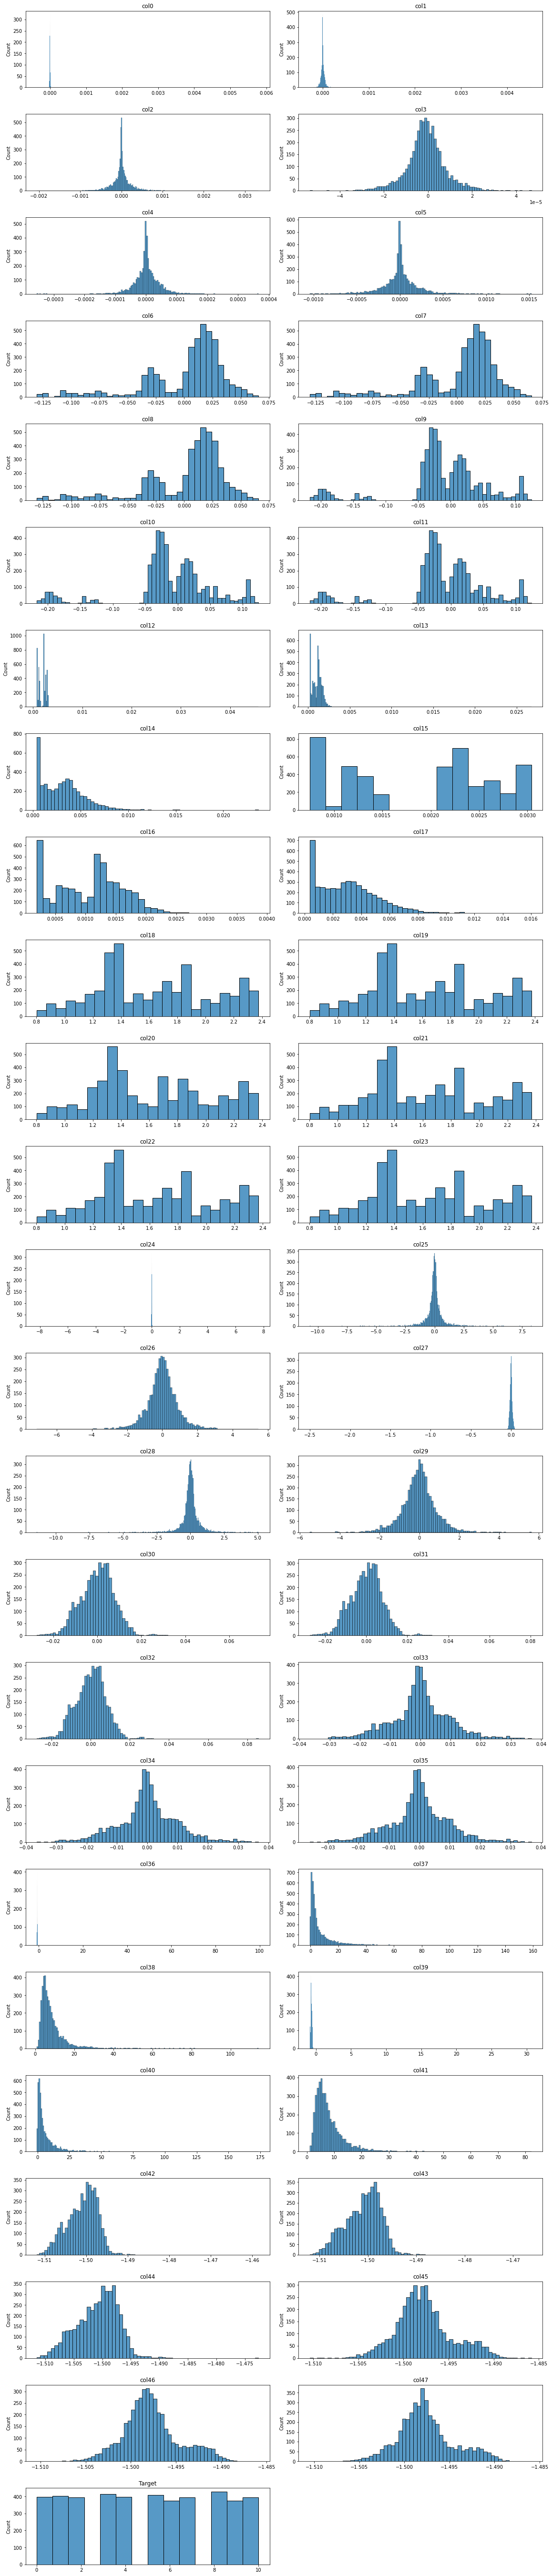

In [9]:
# plot histograms of the training data

ncol, nrow = 2, int(np.ceil(len(df_train.columns)/2))
figsize = (16,3*nrow)

plot_hist(df_train.sample(frac=0.1, random_state=0), figsize, nrow, ncol)

In [10]:
# clip outlier values
pd.options.mode.chained_assignment = None # None / 'warn'

for feature in continuous_features:
    lower = np.percentile(df_train[feature], 2)
    upper = np.percentile(df_train[feature], 98)
    
    df_train.loc[df_train[feature]<lower, feature] = lower
    df_train.loc[df_train[feature]>upper, feature] = upper
    df_test.loc[df_test[feature]<lower, feature] = lower
    df_test.loc[df_test[feature]>upper, feature] = upper

In [11]:
# scaling

scaler_list = [MinMaxScaler(clip=True), MinMaxScaler(clip=True)]   ### StandardScaler() / MinMaxScaler(clip=True)
feature_list = [continuous_features, categorical_features]
df_train_scaled, df_test_scaled = scale_features(df_train, df_test, feature_list, scaler_list)

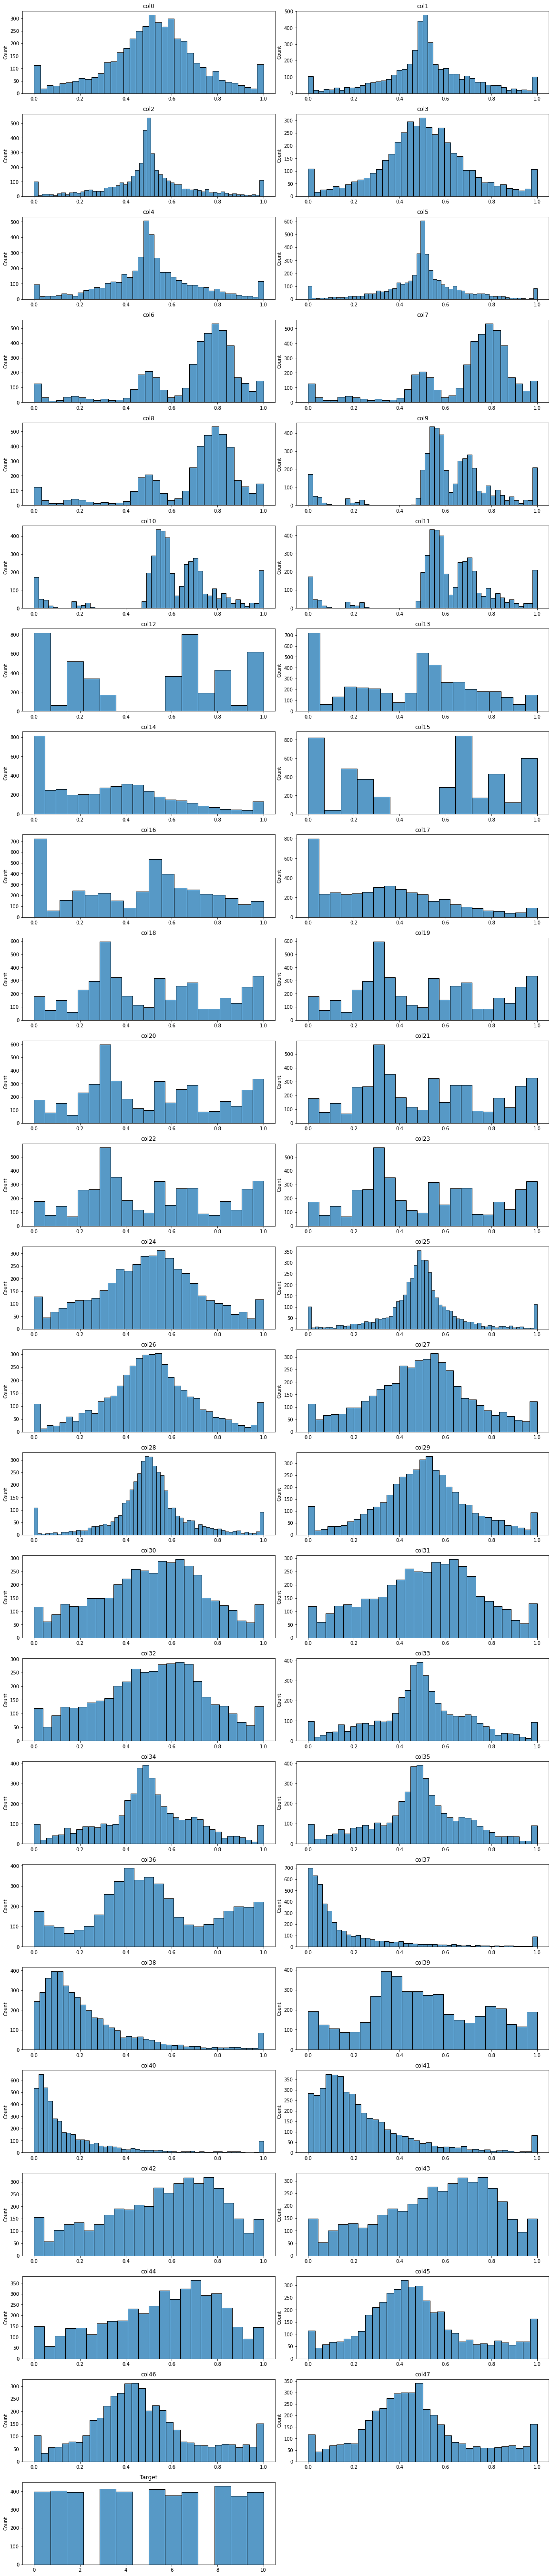

In [12]:
plot_hist(df_train_scaled.sample(frac=0.1, random_state=0), figsize, nrow, ncol)

In [13]:
df_train_scaled

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,Target
0,0.917776,0.116195,0.399908,0.707119,0.449781,1.000000,0.796727,0.797265,0.798219,0.613152,0.613136,0.611390,0.938115,0.921633,0.605267,0.948727,0.763390,0.775875,0.933743,0.933601,0.933837,0.927700,0.927760,0.927582,0.000000,0.187538,0.445791,0.559779,0.457886,0.730697,0.969515,0.974899,0.972318,0.606149,0.606690,0.606212,0.849011,0.101800,0.118309,0.782032,0.034376,0.143150,0.798561,0.785714,0.776978,0.155039,0.161538,0.169231,5
1,0.599776,0.504813,0.517348,0.284685,0.492506,0.711715,0.756811,0.756897,0.757071,0.562161,0.562117,0.561429,0.141145,0.131137,0.219361,0.170494,0.200494,0.161125,0.191864,0.191877,0.191868,0.193277,0.193307,0.193218,0.309537,0.475500,0.475524,0.673709,0.626655,0.947532,0.609474,0.609790,0.605108,0.453954,0.453958,0.444629,0.602840,0.113260,0.558362,0.311042,0.215214,0.475570,0.733813,0.742857,0.748201,0.503876,0.507692,0.476923,5
2,0.398211,0.512773,0.473950,0.500528,0.504673,0.517341,0.061543,0.061521,0.061864,0.006172,0.006083,0.006063,0.014355,0.008244,0.023057,0.016792,0.007806,0.002428,0.394848,0.394875,0.395059,0.394456,0.394513,0.394740,0.585835,0.490074,0.000000,0.410978,0.502415,0.607193,0.233626,0.233280,0.234072,0.542221,0.542396,0.541927,0.703354,0.094317,1.000000,0.753487,0.033465,0.101882,0.935252,0.935714,0.928058,0.263566,0.269231,0.253846,10
3,0.435528,0.534017,0.519149,0.404852,0.498400,0.505105,0.123394,0.123350,0.123402,0.000000,0.000000,0.000000,0.001875,0.055066,0.040185,0.005376,0.012756,0.000000,0.103498,0.103506,0.103512,0.105257,0.105275,0.105346,0.488101,1.000000,0.612576,0.626905,0.472553,0.474422,0.000000,0.000000,0.000000,0.610663,0.610899,0.610230,0.648139,1.000000,0.742289,0.686797,0.209066,0.089394,1.000000,1.000000,1.000000,0.310078,0.315385,0.300000,10
4,0.574387,0.466414,0.505688,0.626097,0.480348,0.489643,0.774843,0.774981,0.775228,0.778472,0.778452,0.778503,0.003580,0.014605,0.008571,0.010959,0.009105,0.024579,0.062093,0.062098,0.062155,0.061503,0.061509,0.061549,0.425317,0.504206,0.571861,0.274465,0.441181,0.539629,0.706180,0.706771,0.704529,0.467272,0.467125,0.465455,0.516058,0.160527,0.134293,0.590971,0.101370,0.225319,1.000000,1.000000,1.000000,0.441860,0.446154,0.430769,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43876,0.420603,0.505401,0.501739,0.441202,0.497020,0.499157,0.083421,0.083409,0.083567,0.000000,0.000000,0.000000,0.012327,0.005084,0.003402,0.016344,0.039181,0.026378,0.392982,0.392940,0.393192,0.394733,0.394790,0.395017,0.620022,0.476790,0.448003,0.536679,0.471421,0.662791,0.000000,0.000000,0.000000,0.636431,0.636723,0.636518,0.742448,0.026449,0.173152,0.766605,0.283008,0.513942,1.000000,1.000000,1.000000,0.434109,0.438462,0.423077,10
43877,0.522783,1.000000,0.679486,0.849646,0.264247,0.553250,0.776238,0.775346,0.774435,0.566885,0.566971,0.566810,0.991081,1.000000,0.811610,0.941603,0.744947,0.799566,0.913846,0.913702,0.913372,0.917728,0.917786,0.916841,0.164500,0.660396,0.553813,0.185927,0.426256,0.422017,0.415450,0.413129,0.410378,0.781293,0.782774,0.783547,0.884964,0.302086,0.077846,0.844436,0.031649,0.074652,0.151079,0.164286,0.187050,0.527132,0.530769,0.484615,0
43878,0.185352,0.430803,0.582064,0.396136,0.141347,0.418709,0.780078,0.780255,0.779999,0.766684,0.766853,0.767143,0.830146,0.649360,0.656722,0.849398,0.786966,0.737557,0.671066,0.671044,0.670705,0.675067,0.675093,0.674570,0.739559,0.486941,0.620802,0.459015,0.273715,0.378479,0.238135,0.237938,0.241401,0.692034,0.692809,0.700760,0.646841,0.017221,0.061637,0.563325,0.097949,0.057585,0.287770,0.292857,0.280576,0.604651,0.607692,0.592308,7
43879,0.965